#Кластерный анализ 

### Загрузка пакетов и импорт библиотек

In [ ]:
pip install plotting

In [ ]:
pip install dask[dataframe]

In [ ]:
pip install geopandas

In [ ]:
pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#hdbscan


In [ ]:
import random
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.cluster import KMeans, Birch, SpectralClustering, OPTICS, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
import pickle
import hdbscan
from pandas.plotting import parallel_coordinates


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
p_data = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Climate/cluster_this.parquet')
data = dd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Climate/cluster_this.parquet')

In [ ]:
# csv for elki
d = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Climate/cluster_this.csv')
d = d.drop(['region'], axis='columns')
d = d.drop(['FID_1'], axis='columns')
d.to_csv('/content/drive/MyDrive/Colab Notebooks/Climate/cluster_this.csv')

### Описание данных


Биоклиматические переменные:
+ BIO1 = Annual Mean Temperature
+ BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
+ BIO3 = Isothermality (BIO2/BIO7) (×100)
+ BIO4 = Temperature Seasonality (standard deviation ×100)
+ BIO5 = Max Temperature of Warmest Month
+ BIO6 = Min Temperature of Coldest Month
+ BIO7 = Temperature Annual Range (BIO5-BIO6)
+ BIO8 = Mean Temperature of Wettest Quarter
+ BIO9 = Mean Temperature of Driest Quarter
+ BIO10 = Mean Temperature of Warmest Quarter
+ BIO11 = Mean Temperature of Coldest Quarter
+ BIO12 = Annual Precipitation
+ BIO13 = Precipitation of Wettest Month
+ BIO14 = Precipitation of Driest Month
+ BIO15 = Precipitation Seasonality (Coefficient of Variation)
+ BIO16 = Precipitation of Wettest Quarter
+ BIO17 = Precipitation of Driest Quarter
+ BIO18 = Precipitation of Warmest Quarter
+ BIO19 = Precipitation of Coldest Quarter

In [ ]:
data.head()

Longitude  Latitude     BIO_1     BIO_2  ...  BIO_17  BIO_18  BIO_19  region
FID_1                                           ...                                
352        28.25     70.45 -0.761500  6.179667  ...      93     161     111    None
353        28.55     70.45 -0.439706  6.266667  ...      94     162     111    None
354        25.55     70.35  0.988500  6.173000  ...      95     151     123    None
355        28.15     70.35 -0.473500  7.794333  ...      70     144     100    None
356        28.15     70.25 -0.972833  7.595000  ...      79     154     100    None

[5 rows x 22 columns]

In [ ]:
data.tail()

Longitude  Latitude      BIO_1     BIO_2  ...  BIO_17  BIO_18  BIO_19  region
FID_1                                             ...                                
308215     121.45     15.05  26.157167  7.154334  ...     216     870     394    None
308217     121.95     15.05  27.042857  7.309524  ...     304     662     636    None
308514     145.65     16.35  26.499740  5.328646  ...     251     661     282    None
308517     145.75     15.15  27.564583  5.237500  ...     250     462     272    None
308518     145.65     15.05  27.654167  5.241667  ...     247     458     272    None

[5 rows x 22 columns]

In [ ]:
p_data.describe()

Longitude       Latitude  ...         BIO_18         BIO_19
count  298899.000000  298899.000000  ...  298899.000000  298899.000000
mean       27.044013      40.569837  ...     246.565291     111.264236
std        74.479758      11.763294  ...     201.250489     100.723531
min      -159.750000      15.050000  ...       0.000000       0.000000
25%        -2.450000      32.150000  ...     135.000000      41.000000
50%        41.050000      41.550000  ...     211.000000      89.000000
75%        82.150000      50.550000  ...     305.000000     145.000000
max       147.950000      70.450000  ...    5425.000000    3427.000000

[8 rows x 21 columns]

In [ ]:
data.dtypes

Longitude    float64
Latitude     float64
BIO_1        float64
BIO_2        float64
BIO_3        float64
BIO_4        float64
BIO_5        float64
BIO_6        float64
BIO_7        float64
BIO_8        float64
BIO_9        float64
BIO_10       float64
BIO_11       float64
BIO_12         int64
BIO_13         int64
BIO_14         int64
BIO_15       float64
BIO_16         int64
BIO_17         int64
BIO_18         int64
BIO_19         int64
region        object
dtype: object

In [ ]:
pd.unique(data['region'])

array([None, 'Рязанская область', 'Пензенская область',
       'Тульская область', 'Орловская область', 'Курская область',
       'Липецкая область', 'Тамбовская область'], dtype=object)

Проверка пропущенных значений:

In [ ]:
p_data.isnull().any().any()

True

In [ ]:
len(data), len(data.dropna())

(298899, 222)

In [ ]:
p_data.drop(['region'], axis='columns').isnull().any().any()

False

  Пропущенные значения содержатся только в столбце "регион", являющемся категориальным признаком. Из всего набора данных значение этого поля не пропущено только у 222 объектов, поэтому использовать методы импутации не будем.

In [ ]:
x = data.drop(['region'], axis='columns') #dask dataframe
p_x = p_data.drop(['region'], axis='columns') #pandas dataframe

Масштабирование признаков:

In [ ]:
from sklearn.preprocessing import MinMaxScaler    
scaler=MinMaxScaler()
xscaled=pd.DataFrame(scaler.fit_transform(x),columns=x.columns)

 Визуализация объектов на карте мира по широте и долготе:

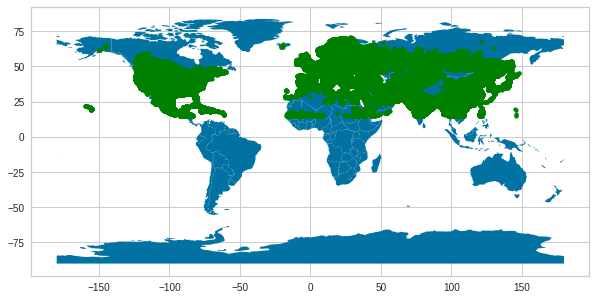

In [ ]:
geometry = [Point(xy) for xy in zip(p_data['Longitude'], p_data['Latitude'])]
gdf = GeoDataFrame(p_data, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='green', markersize=15)

Исходя из природы данных (статические климатические характеристики), логично предположить, что кластеры будут представлять собой некоторые типы климата.

Карта типов климата по классификации Кёппена, основывающейся на концепции, в соответствии с которой наилучшим критерием типа климата является то, какие растения растут на данной территории в естественных условиях:

In [ ]:
from IPython.core.display import Image, display
display(Image(url='https://cdn.britannica.com/67/188767-050-DD04AF29/types-patterns-precipitation-vegetation-temperature-map-classification-1900.jpg',
              width=600, unconfined=True))

### Рабрта с выбросами

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



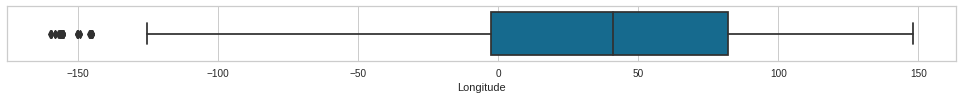

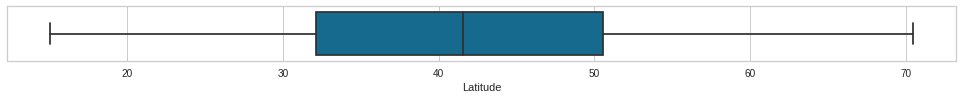

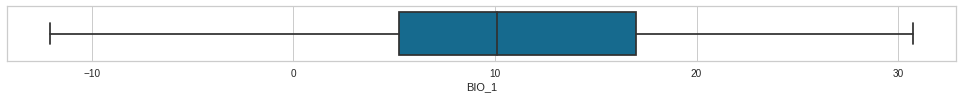

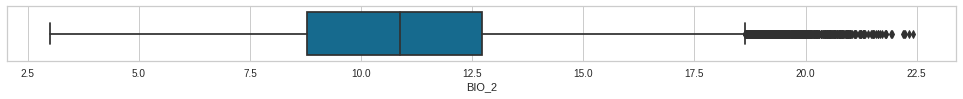

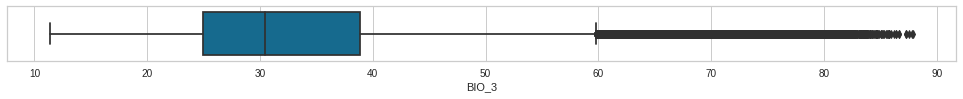

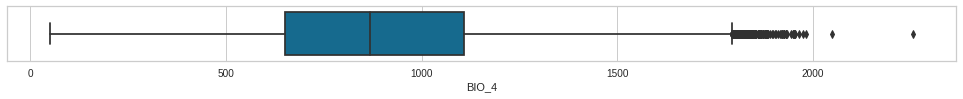

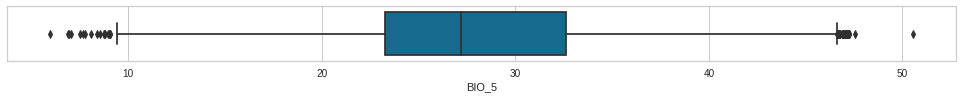

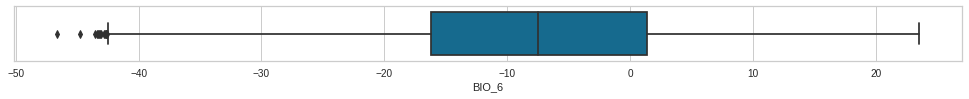

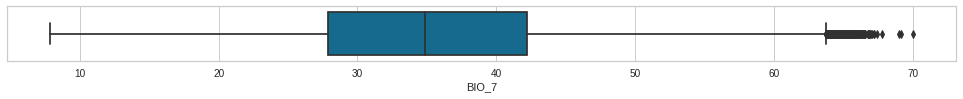

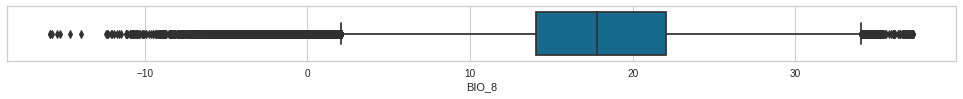

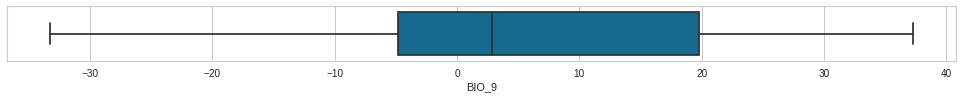

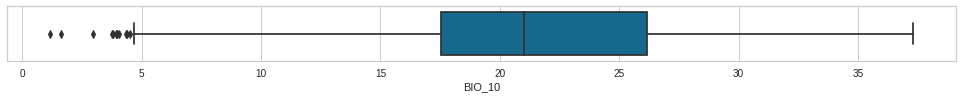

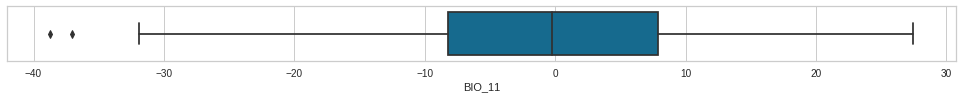

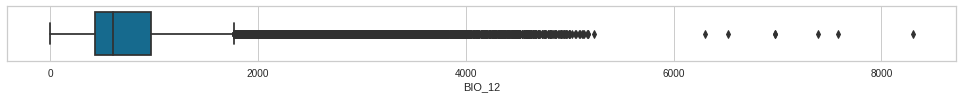

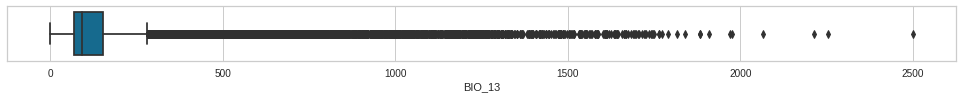

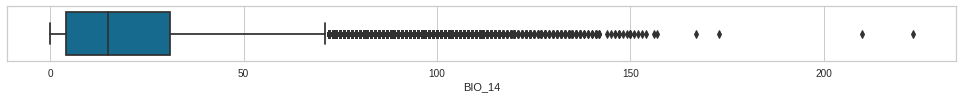

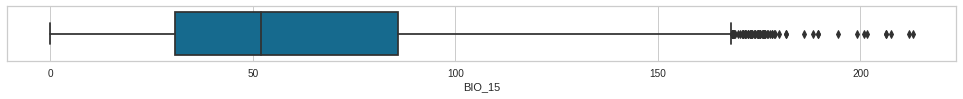

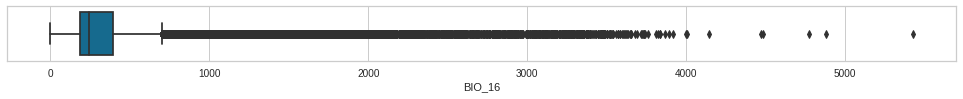

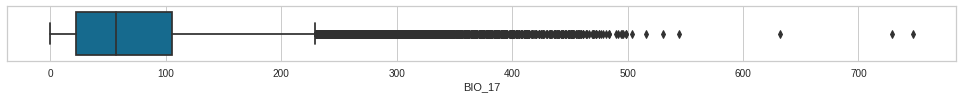

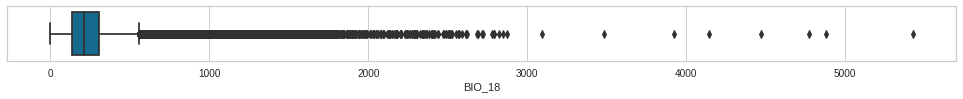

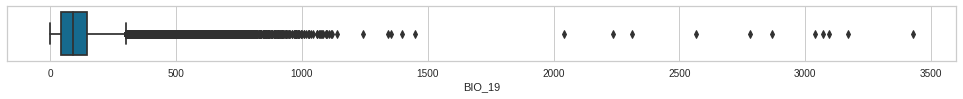

In [ ]:
for column in p_x:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=p_x, x=column)

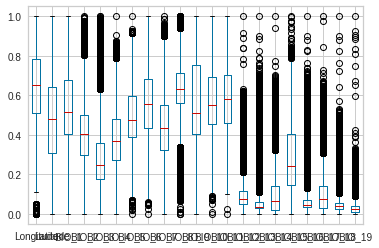

In [ ]:
xscaled.plot.box()
plt.show()

График плотностей распределений признаков:

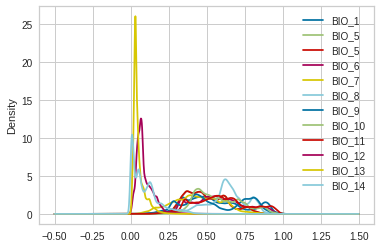

In [ ]:
subset = xscaled[['BIO_1', 'BIO_5', 'BIO_5', 'BIO_6',
         'BIO_7', 'BIO_8', 'BIO_9', 'BIO_10', 
         'BIO_11', 'BIO_12', 'BIO_13', 'BIO_14']]

subset.plot.kde()

Даже после масштабирования переменные не распределяются нормально. Есть потребность в использовани РСА для уменьшение атрибутов и получение той же дисперсии.

## Понижение размерности

График зависимости объясненной дисперсии от размерности:

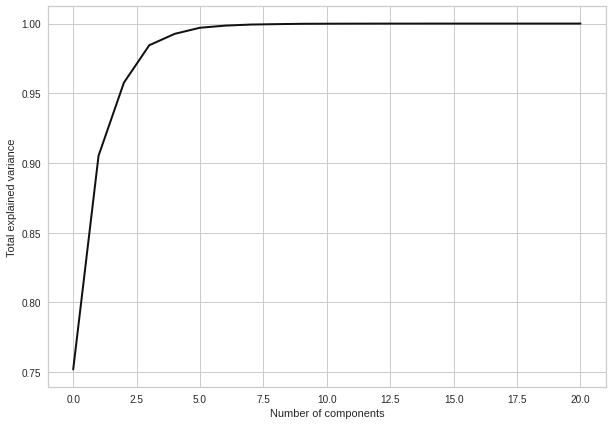

In [ ]:
pca = decomposition.PCA().fit(x)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.show()

Согласно построенному графику можно уменьшить размерность данных до 5, потеряв наименьшее количество информации.

In [ ]:
#3 components
pca = decomposition.PCA(n_components=3)
pca.fit(x)
x_3d = dask.array.from_array(pca.transform(x))

In [ ]:
#5 components
pca = decomposition.PCA(n_components=5)
pca.fit(x)
x_5d = dask.array.from_array(pca.transform(x))

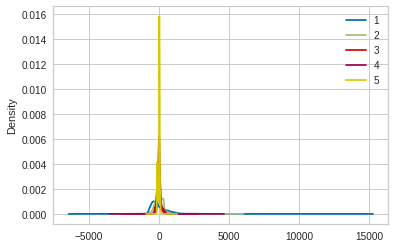

In [ ]:
pdf=pd.DataFrame(data=pca.transform(x), columns=['1','2','3','4','5'])
pdf.plot.density()
plt.show()

Вполне нормально.

## Кластеризация

### Выбор оптимального количества кластеров


Метод локтя для поиска оптимального количества кластеров:

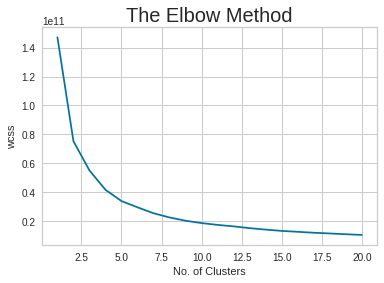

In [ ]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x_3d)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 21), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

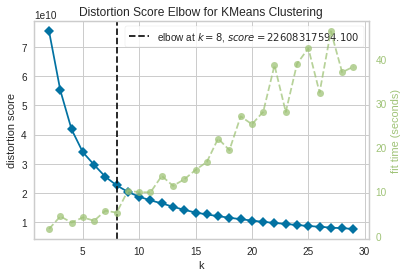

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(x_3d)       
visualizer.show()    

Точка локтя была достигнута при 8 кластерах. 

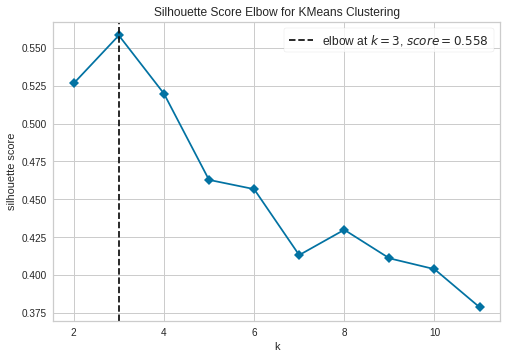

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette', timings= False)
visualizer.fit(x_3d[:50000])        
visualizer.show()

### Построение моделей

In [ ]:
models = []

K-Means:

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=0, algorithm='full').fit(x)
models.append(kmeans)

Spectral Clustering:

In [ ]:
spectral = SpectralClustering(n_clusters=8, random_state=1,
                                    affinity='nearest_neighbors').fit(x_3d)
spec_labels = spectral.labels_
np.savetxt('/content/drive/MyDrive/Colab Notebooks/Climate/spectral_clusters.txt', spec_labels, delimiter=',') 
pickle.dump(spectral, open("/content/drive/MyDrive/Colab Notebooks/Climate/spectral_model.pkl", "wb"))

In [ ]:
spectral = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/spectral_model.pkl", "rb"))
models.append(spectral)

HDBSCAN

In [ ]:
hdbsc = hdbscan.HDBSCAN(min_cluster_size=1100, gen_min_span_tree=False)
hdbsc.fit(x)
pickle.dump(hdbsc, open("/content/drive/MyDrive/Colab Notebooks/Climate/hdbscan_model.pkl", "wb"))

In [ ]:
hdbsc = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Climate/hdbscan_model.pkl", "rb"))
models.append(hdbsc)

In [ ]:
from collections import Counter
Counter(hdbsc.labels_)

Counter({-1: 150305,
         0: 1295,
         1: 947,
         2: 9081,
         3: 46385,
         4: 1332,
         5: 14362,
         6: 5480,
         7: 835,
         8: 6770,
         9: 18650,
         10: 1583,
         11: 41874})

In [ ]:
models


[KMeans(algorithm='full', random_state=0),
 SpectralClustering(affinity='nearest_neighbors', random_state=1),
 HDBSCAN(gen_min_span_tree=True, min_cluster_size=800)]

In [ ]:
#optics = OPTICS().fit(x_3d)  ### memory error
#pickle.dump(spectral, open("/content/drive/MyDrive/Colab Notebooks/optics_model.pkl", "wb"))

In [ ]:
#birch = Birch( n_clusters=8).fit(x_3d)   ### memory error
#pickle.dump(spectral, open("/content/drive/MyDrive/Colab Notebooks/birch_model.pkl", "wb"))

In [ ]:
dbsc = DBSCAN(min_samples=1000).fit(x)

In [ ]:
Counter(dbsc.labels_)

Counter({-1: 298899})

In [ ]:
#Hierarchical   ### memory error
Z = linkage(x_5d, 'ward')
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(x_5d))

# dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

### Сравнение метрик различных моделей:

In [ ]:
metric = []
for model in models:
   metric.append(({
        'Davies-Bouldin Index': metrics.davies_bouldin_score(x, model.labels_), #lower - better
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(x, model.labels_),# higher - better
        'Silhouette': metrics.silhouette_score(p_x.iloc[1:5000], model.labels_[1:5000])
        })) # higher - better
results = pd.DataFrame(data=metric, columns=['Davies-Bouldin Index', 'Calinski-Harabasz Score','Silhouette'],
                       index=['K-means', 'Spectral', 'HDBSCAN'])
results


Davies-Bouldin Index  Calinski-Harabasz Score  Silhouette
K-means               1.058692            185839.743644    0.332913
Spectral              1.274010            126513.238605    0.700038
HDBSCAN               1.737645              7792.983164    0.383887

### DBSCAN

In [ ]:
def check_core_point(eps,minPts, df, index):
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    if len(temp) >= minPts:
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        return (temp.index , False, False, True)

def cluster_with_stack(eps, minPts, df):
    C = 1
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0):
        first_point = True
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0:
            curr_idx = current_stack.pop()
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
          
            if (isborder & first_point):
     
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
              
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) 
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) 
            
            if iscore: 
                first_point = False
                
                clusters.append((curr_idx,C)) 
                current_stack.update(neigh_indexes)
            elif isborder: 
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise:
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            C+=1
        
    return clusters

In [ ]:
eps = 0.6
minPts = 3
clustered = cluster_with_stack(eps, minPts, x)

In [ ]:
set(dbscan.labels_)

{-1}

 # Визуализация кластеров

### KMeans

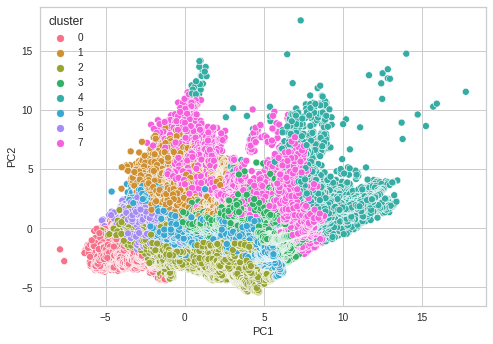

In [ ]:
Sc = StandardScaler()
X = Sc.fit_transform(data.drop(columns='region'))
pca = decomposition.PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
pca_data['cluster'] = pd.Categorical(kmeans.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)

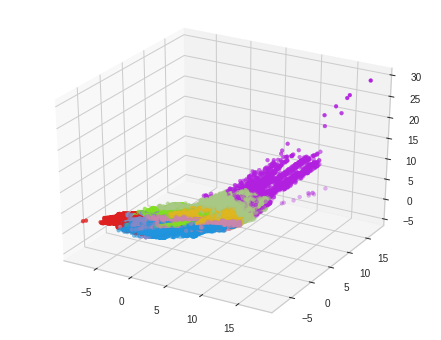

In [ ]:
pca = decomposition.PCA(3) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2','PC3']) 
pca_data['cluster'] = pd.Categorical(kmeans.labels_)

colors = ['#DF2020', '#81DF20', '#2095DF', '#dfb620', '#b220df', '#c985ac', '#8588c9',
          '#a8c985','#1b1e2e']
pca_data['c'] = pca_data.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3],
                                      4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7],
                                      8:colors[8]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(pca_data.PC1, pca_data.PC1, pca_data.PC3, c=pca_data.c, s=15)
plt.show()

In [ ]:
p_data['kmeans_labels'] = pd.Categorical(kmeans.labels_)

In [ ]:
data = shuffle(p_data)
fig = px.scatter_geo(data,lat='Latitude',lon='Longitude', color="kmeans_labels")
fig.update_layout(title = 'Clusters on map', title_x=0.5)
fig.show()

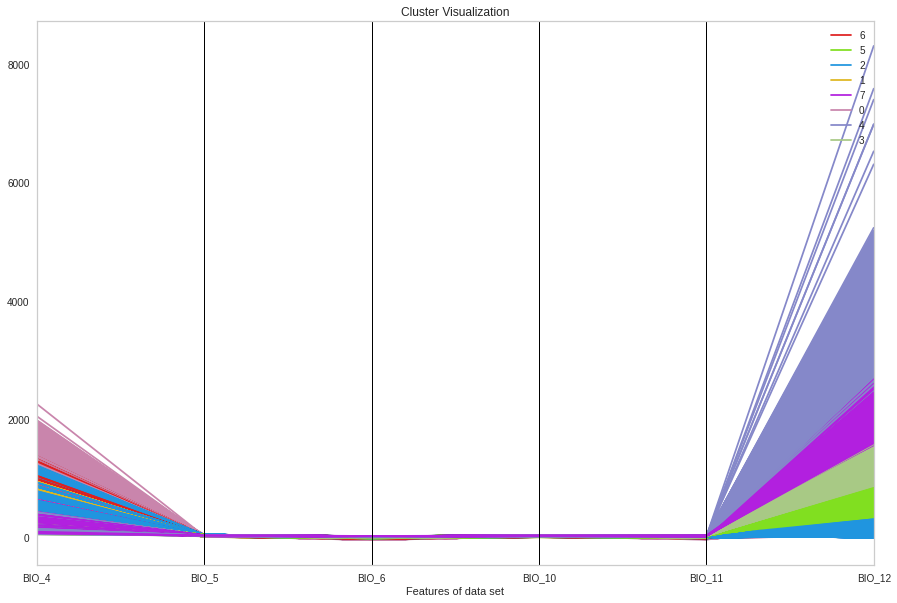

In [ ]:
plt.figure(figsize=(15,10))
parallel_coordinates(p_data, 'kmeans_labels', cols=['BIO_4','BIO_5', 'BIO_6',
                                                     'BIO_10','BIO_11','BIO_12'],
                     color=('#DF2020', '#81DF20', '#2095DF', '#dfb620', 
                               '#b220df', '#c985ac', '#8588c9','#a8c985'))
plt.title("Cluster Visualization")
plt.xlabel("Features of data set")
plt.show()

### Spectral Clustering

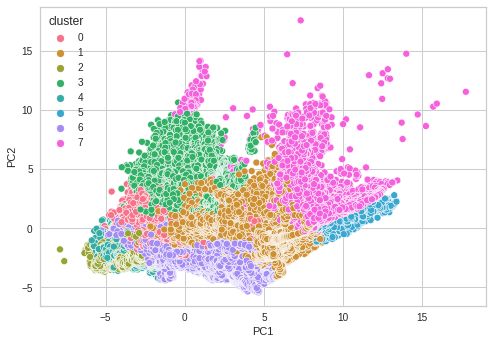

In [ ]:
X = Sc.fit_transform(data.drop(columns='region'))
pca = decomposition.PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
pca_data['cluster'] = pd.Categorical(spectral.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)

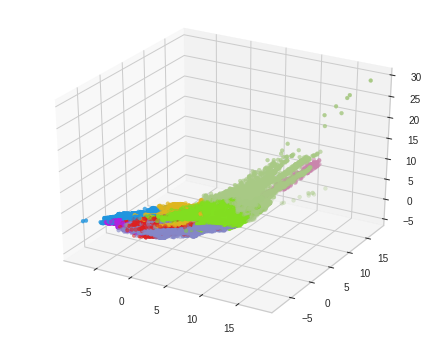

In [ ]:
pca = decomposition.PCA(3) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2','PC3']) 
pca_data['cluster'] = pd.Categorical(spectral.labels_)

colors = ['#DF2020', '#81DF20', '#2095DF', '#dfb620', '#b220df', '#c985ac', '#8588c9',
          '#a8c985']
pca_data['c'] = pca_data.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3],
                                      4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(pca_data.PC1, pca_data.PC1, pca_data.PC3, c=pca_data.c, s=15)
plt.show()

In [ ]:
p_data['spectral_labels'] = pd.Categorical(spectral.labels_)

Кластеры на карте:

In [ ]:
data = shuffle(p_data)
fig = px.scatter_geo(data.iloc[:50000],lat='Latitude',lon='Longitude', color="spectral_labels")
fig.update_layout(title = 'Clusters on map', title_x=0.5)
fig.show()

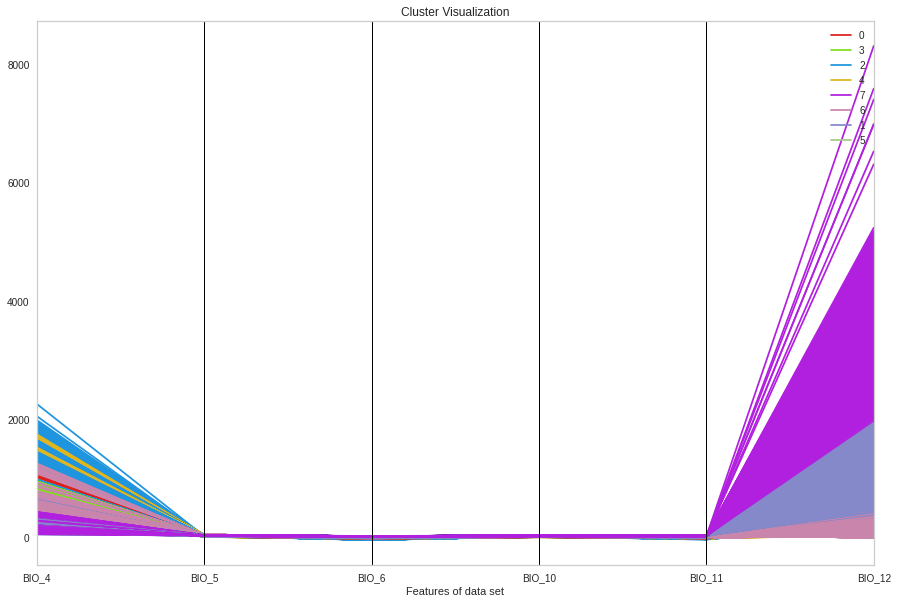

In [ ]:
plt.figure(figsize=(15,10))
parallel_coordinates(p_data, 'spectral_labels', cols=['BIO_4','BIO_5', 'BIO_6',
                                                     'BIO_10','BIO_11','BIO_12'],
                     color=('#DF2020', '#81DF20', '#2095DF', '#dfb620', 
                               '#b220df', '#c985ac', '#8588c9','#a8c985'))
plt.title("Cluster Visualization")
plt.xlabel("Features of data set")
plt.show()

## Описание кластеров:

Описательная статистика по кластерам:

In [ ]:
p_data.groupby(['kmeans_labels']).describe()

Longitude                        ... BIO_19               
                  count       mean        std  ...    50%    75%     max
kmeans_labels                                  ...                      
0               61489.0  53.534760  77.261667  ...   49.0   62.0   158.0
1               39023.0  -1.938415  92.207032  ...  219.0  306.0   747.0
2               41510.0  19.671062  63.573314  ...   80.0  121.0   290.0
3               23263.0  44.929727  76.618951  ...   34.0   52.0   726.0
4                3229.0  65.036250  68.101204  ...   38.0  116.0  3427.0
5               45455.0  10.809828  45.344510  ...  159.0  213.0   584.0
6               68997.0  15.871486  68.586217  ...  105.0  120.0   467.0
7               15933.0  75.885185  67.710110  ...  111.0  201.0  1449.0

[8 rows x 168 columns]

Анализируя карту, с отмеченными на ней кластерами, и описательную статистику по кластерам, можно увидеть соответствие номера кластера типу климата:
+ 0 - холодный (континентальный) без сухого сезона
+ 1 - умеренный без сухого сезона, с холодным летом
+ 2 - сухой пыстынный
+ 3 - тропический мусонный и саванн
+ 4 - умеренный с теплым летом
+ 5 - сухой степной
+ 6 - умеренный без сухого сезона, с теплым летом
+ 7 - тропический влажный

In [ ]:
p_data.groupby(['region', 'kmeans_labels','spectral_labels']).describe()

Longitude  ... BIO_19
                                                     count  ...    max
region             kmeans_labels spectral_labels            ...       
Курская область    6             0                    47.0  ...  125.0
Липецкая область   6             0                    28.0  ...  110.0
Орловская область  6             0                     6.0  ...  110.0
Пензенская область 6             0                     4.0  ...  111.0
                                 4                    23.0  ...  110.0
                   0             4                     4.0  ...  103.0
Рязанская область  6             0                    64.0  ...  114.0
Тамбовская область 6             0                    17.0  ...  117.0
Тульская область   6             0                    29.0  ...  112.0

[9 rows x 168 columns]

Все регионы, указанные в стобце "region" находятся в центральной части России на одной широте и имеют схожие климатические характеристики. Метод кластеризации K-means отнес их к одному кластеру 0, соответствующему умеренному климату без сухого сезона с теплым летом.

In [ ]:
data = p_data.dropna()
fig = px.scatter_geo(data,lat='Latitude',lon='Longitude', color="kmeans_labels")
#fig.update_layout(title = 'Clusters on map', title_x=0.5, geo_scope='europe')
fig.show()